In [2]:
import numpy as np
import random
import pickle
import collections
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import math
import json
#global variables
NumberOfStepsInGame = 10
wins = 0
losses = 0
allpnlsAtTheEnd = []

class State():
    def __init__(self, mm):
        self.inventory = 0;
        self.mm = mm
        self.isEnd = False
        self.stateHash = None
        self.possibleActionsFromClient = list(np.linspace(-10,10,201))
        self.possibleActionsToHedge =    list(np.linspace(-10,10,2001))
        self.pnl = 0
        self.wins = 0
        self.losses = 0    
        self.volatility = 0.05
        self.spread = 0.005
        self.price = 1
        self.impactBps = 0
        self.cost = {'pmi': 0.005, 'psi': 0.1, 'eta': 1.e-5}
        self.priceAmountDict = {}
        self.oldWa = 1
        self.pnlAtLastStep = 0
        self.depthConst = {15, 15, 15}
        self.oldPnl = 0
        self.maxHedgingAmount = 100

      #get unique hash of current board state
    def getHash(self):
        self.stateHash = str(self.inventory)
        return self.stateHash
    
    def winner(self, stepNumber):
        if stepNumber == NumberOfStepsInGame-1:
            self.isEnd = True
            if self.pnl > 0:
                return 1;
            elif self.pnl == 0: 
                return 0;
            else:
                return -1;
        else:
            self.isEnd = False
            return None
  

    def updateState(self, position, fromClient):
        #check client price with regards to spread
        currWa = self.getWa()
        if position > 0:
            priceWithSpread = self.price + (self.spread/2)
            if self.oldWa is not None:  
                diffWaCurrPrice = priceWithSpread - self.oldWa
            else:
                diffWaCurrPrice = priceWithSpread - currWa
        else:
            priceWithSpread = self.price + (self.spread/2)
            if self.oldWa is not None:
                diffWaCurrPrice = self.oldWa - priceWithSpread
            else:
                diffWaCurrPrice = currWa - priceWithSpread
        self.oldWa = None
        if fromClient == True:
            #else we just adjust our inventory
            self.inventory = self.inventory - position
            self.inventory = float(self.inventory)
        else:
            #execute hedge
            self.inventory = self.inventory + position
            #adjust for risk
            self.pnl = self.pnl - ((self.inventory**2)*self.volatility)
            #impact and trading cost
            self.impactBps += self.cost['pmi']*position/86400
            cost = 1e-4*np.sign(position/NumberOfStepsInGame) * (self.cost['psi'] + self.cost['eta'] * \
                                                                 np.abs(position/NumberOfStepsInGame)) 
          
    def updatePrice(self):
        dt_sec = 1
        random_bps = np.random.normal(0, self.volatility * np.sqrt(dt_sec/86400))
        self.price *= 1 + 1e-4 * (random_bps) + self.impactBps
        self.impactBps = 0
  
  # only when game ends
    def giveReward(self, currStep, currPnl):
        result = self.winner(currStep)
        # backpropagate reward
        self.mm.feedReward(self.getRewardAmount(self.pnl))#currPnl-self.pnlAtLastStep)
        if result == 1:
            self.wins = self.wins + 1;
        elif result == -1:
            self.losses = self.losses + 1
        return self.getRewardAmount(self.pnl)

    def reset(self):
        self.inventory = random.choice(list(np.linspace(-100,100, 201)))#0
        self.pnl = 0
        self.pnlAtLastStep = 0
        self.boardHash = None
        self.isEnd = False
        self.price = 1
        self.oldPnl = 0
      
    def getAvailableHedgePositions(self):
        if self.inventory < 0:
            avPos = [n for n in self.possibleActionsToHedge if n >= 0 and abs(n) <= abs(self.inventory)]
        elif self.inventory > 0:
            avPos = [n for n in self.possibleActionsToHedge if n <= 0 and abs(n) <= abs(self.inventory)]
        elif self.inventory == 0:
            avPos = [n for n in self.possibleActionsToHedge if n == 0 and abs(n) <= abs(self.inventory)]
        return avPos

    def getWa(self):
        df = pd.DataFrame.from_dict({
            'price': self.priceAmountDict.keys(),
            'Amounts': self.priceAmountDict.values()
        })
        if df['Amounts'].sum() == 0:
            return self.price #no current pos so just return price - no profit or loss, since no position 
        return sum(df['Amounts'] * df['price']) / df['Amounts'].sum()
 
    def updateWa(self, clientAction):
        #if client trade is increasing inventory I update WA price for pnl calculations
        if clientAction > 0:
            priceWithSpread = self.price + (self.spread/2)
        else:
            priceWithSpread = self.price - (self.spread/2)
        #if increasing inventory
        if (self.inventory > 0 and clientAction < 0) or (self.inventory < 0 and clientAction > 0):
            if self.price in self.priceAmountDict:
                self.priceAmountDict[priceWithSpread] += clientAction
            else:
                self.priceAmountDict[priceWithSpread] = clientAction
        elif (self.inventory > 0 and clientAction > 0) or (self.inventory < 0 and clientAction < 0):
            if (self.inventory > 0 and (self.inventory - clientAction <= 0)) or (self.inventory < 0 \
                                                                                 and (self.inventory \
                                                                                      - clientAction >= 0)):
                #initialize only with next trade
                self.oldWa = self.getWa()
                self.priceAmountDict = {}
                self.priceAmountDict[priceWithSpread] = abs(clientAction) - abs(self.inventory)
        else:
            #INVENTORY IS 0 or clientAction is 0
            self.priceAmountDict[priceWithSpread] = clientAction
            
    def clientsTrade(self, currStep):
        avPos = self.possibleActionsFromClient
        clientAction = random.choice(avPos)
        #get amount and sign of client trade
        deltaA = 0.95
        deltaB = 0.5
        At = np.random.binomial(1, deltaA)
        Bt = np.random.binomial(1, deltaB)
        D = (At * (2*Bt-1))
        clientAction = np.random.normal(0,8,1)[0]*D
        if clientAction > 0:
            priceWithSpread = self.price + (self.spread/2)
        else:
            priceWithSpread = self.price - (self.spread/2)
        if abs(self.inventory - clientAction) < 100:
            #Update weighted average of price calculations
            self.updateWa(clientAction)
            #update state
            self.updateState(clientAction, True)
        win = self.winner(currStep);
        return win

    
    def hedgeTrade(self):
        avPos = self.getAvailableHedgePositions()

        action = self.mm.chooseAction(avPos, self.inventory)
        #reset weighted average price if hedging 100%
        if action == -self.inventory:
            self.priceAmountDict = {}

        #get instant market impact
        instantMI = 0.0005*abs(action)
        self.pnl = self.pnl - (abs(action)*self.spread/2) - instantMI
        self.updateState(action, False)
        stateString = str(self.inventory)
        self.mm.addState(stateString)

        self.impactBps = self.cost['pmi'] * action
        return action, self.impactBps, instantMI

    def updateStep(self, currStep):
        if currStep == NumberOfStepsInGame-1:
            currStep = 0
            self.isEnd = True
        else:
            currStep = currStep + 1
        return currStep

    
    def getRewardAmount(self, currPnl):
        return ((self.pnl-self.oldPnl + 500))
 
    def train(self, rounds=100000, maxHedgingAmount = 100):
        normStatesValuesVector=[]
        self.maxHedgingAmount = maxHedgingAmount
        currStep = 0;
        allpnlsAtTheEnd = []
        for i in range(0, rounds): #play rounds many action reward combinations
            while not self.isEnd:
                self.oldPnl = self.pnl

                #Trade with client
                win = self.clientsTrade(currStep)

                #Hedge and calculate cost and market impact
                hedgedAmount, priceChange, instantMarketImpact = self.hedgeTrade()

                #update the price
                self.updatePrice()

                #update the step
                currStep = self.updateStep(currStep)

                #check if this action reward combination is over
                win = self.winner(currStep);
                if win is not None:
                    allpnlsAtTheEnd.append(self.pnl)
                    rewardGiven = self.giveReward(currStep, self.pnl)
                    self.mm.reset()
                    self.reset()
                    break
                else:
                    rewardGiven = self.giveReward(currStep, self.pnl)

                normStatesValuesVector.append(np.linalg.norm(list(mm.states_value.values())))


        #after training check values of each state and return them
        afterTrainingStateValues = mm.states_value
        afterTrainingStateValues = {float(k):float(v) for k,v in afterTrainingStateValues.items()}
        stateActionPolicyAfterTraining, theirValues,unsorted = \
        self.mm.getCurrentPolicy(self.possibleActionsToHedge, self.maxHedgingAmount)
        stateActionPolicyAfterTraining = collections.OrderedDict(sorted(stateActionPolicyAfterTraining.items()))
        sortedStateValue = {k: afterTrainingStateValues[k] for k in sorted(afterTrainingStateValues)}
        return stateActionPolicyAfterTraining, sortedStateValue, unsorted, normStatesValuesVector

class marketMaker():
    def __init__(self, name, exp_rate=0.3):
        self.name = name
        self.states = []
        self.lr = 0.2  
        self.exp_rate = exp_rate
        self.decay_gamma = 0.7
        self.states_value = {}
        self.mmOrderBook = {}

    def getHash(self, inventory):
        invHash = str(inventory)
        return invHash

    def getCurrentPolicy(self, allPosibleHedgeAmounts, maxHedgingAmount): #get what is best action 
        StateAction = {}
        theirValues = {}
        imp = 0.005

        allPosibleHedgeAmounts=list(np.linspace(-maxHedgingAmount,maxHedgingAmount,2001))
        for currentInv in self.states_value.keys():
            currentInv = float(currentInv)
            value_max = -999
            action = 0
            for p in allPosibleHedgeAmounts:
                next_inv = currentInv
                next_inv = currentInv + p
                next_stateHash = self.getHash(next_inv)

                currStateHash = self.getHash(currentInv)
                currValue = 0 if self.states_value.get(currStateHash) is None else \
                self.states_value.get(currStateHash)
                value = 0 if self.states_value.get(next_stateHash) is None else \
                self.states_value.get(next_stateHash)
                if value  >= value_max:
                    value_max = value - abs(float(p))*imp#value
                    action = p
                    currVal = value - abs(float(p))*imp#value
            StateAction[currentInv] = action#str(action) + str(currVal)
            theirValues[currentInv] = currVal

        return StateAction, theirValues, self.states_value

    
    
    
    
    def chooseAction(self, availablePositions, currentInv): 
        if np.random.uniform(0, 1) <= self.exp_rate:
            # take random action / explore actions
            idx = np.random.choice(len(availablePositions))
            action = availablePositions[idx]
        else:
            value_max = -999
            for p in availablePositions:
                next_inv = currentInv
                next_inv = currentInv + p
                next_stateString = str(next_inv)
                value = 0 if self.states_value.get(next_stateString) is None \
                or math.isnan(self.states_value.get(next_stateString)) else \
                self.states_value.get(next_stateString)
                if value >= value_max:
                    value_max = value
                    action = p
        return action


    #append a hash state
    def addState(self, state):
        self.states.append(state)

  # at the end of game, backpropagate and update states value
    def feedReward(self, reward):
        for st in reversed(self.states):
            st = str(round(float(st), 0))
            if self.states_value.get(st) is None:
                self.states_value[st] = 0
            self.states_value[st] += self.lr * (self.decay_gamma * reward - self.states_value[st])
            reward = self.states_value[st]
        
    def reset(self):
        self.states = []


training...
training...
training...
training...
training...
training...
training...
training...
training...
training...
training...
training...
training...
training...
training...
training...
training...
training...
training...
training...
training...
training...
training...
training...
training...
training...
training...
training...
training...
training...
training...
training...
training...
training...
training...
training...
training...
training...
training...
training...
training...
training...
training...
training...
training...
training...
training...
training...
training...
training...
training...
training...
training...
training...
training...
training...
training...
training...
training...
training...
training...
training...
training...
training...
training...
training...
training...
training...
training...
training...
training...
training...
training...
training...
training...
training...
training...
training...
training...
training...
training...
training...
training...
trai

training...
training...
training...
training...
training...
training...
training...
training...
training...
training...
training...
training...
training...
training...
training...
training...
training...
training...
training...
training...
training...
training...
training...
training...
training...
training...
training...
training...
training...
training...
training...
training...
training...
training...
training...
training...
training...
training...
training...
training...
training...
training...
training...
training...
training...
training...
training...
training...
training...
training...
training...
training...
training...
training...
training...
training...
training...
training...
training...
training...
training...
training...
training...
training...
training...
training...
training...
training...
training...
training...
training...
training...
training...
training...
training...
training...
training...
training...
training...
training...
training...
training...
training...
trai

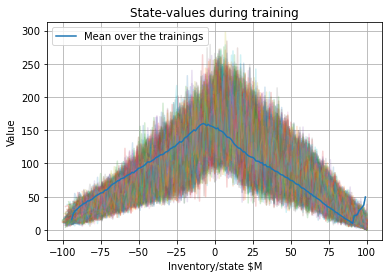

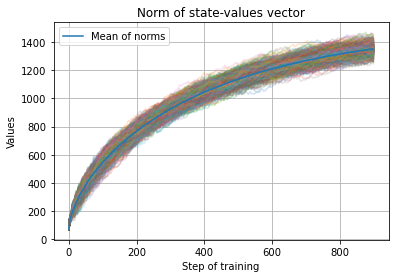

In [4]:
#PLOT STATES VALUES
import statistics
#training and plotting
thePolicyArr = []; stateValuesArr = []; unsortedArr = []; normStatesValArr = []

for i in range(1000):
    mm = marketMaker("mm")
    st = State(mm)
    print("training...")
    thePolicy, stateValues, unsorted, normStatesValuesVector = st.train(100, 10)
    thePolicyArr.append(thePolicy)
    stateValuesArr.append(stateValues)
    unsortedArr.append(unsorted)
    normStatesValArr.append(normStatesValuesVector)

polArr=pd.DataFrame()
sVArr=pd.DataFrame()
unsArr=pd.DataFrame()
normsVal=pd.DataFrame()
for i in range(len(thePolicyArr)):
    polArr = polArr.append(thePolicyArr[i], ignore_index=True)
    sVArr = sVArr.append(stateValuesArr[i], ignore_index=True)
    unsArr = unsArr.append(unsortedArr[i], ignore_index=True)
    normsVal = normsVal.append(normStatesValArr[i], ignore_index=True)
    plt.plot(stateValuesArr[i].keys(),stateValuesArr[i].values(), alpha = 0.2)
meanPol = dict(polArr.mean())
meansVArr = dict(sVArr.mean())
meanunsArr = dict(unsArr.mean())
plt.plot(np.linspace(-94,99,len(meansVArr.values())-15),list(meansVArr.values())[0:len(meansVArr.values())-15],label="Mean over the trainings",)
plt.title('State-values during training')
plt.xlabel('Inventory/state $M')
plt.ylabel('Value')
plt.grid()
plt.legend()
plt.savefig('StatesValMethod1', dpi=500)
plt.show()

#PRINT NORM CONVERGENCE
for i in range(len(thePolicyArr)):
    plt.plot(normStatesValArr[i], alpha = 0.2)
NormMeans = np.mean(normStatesValArr, axis=0)
plt.plot(NormMeans, label='Mean of norms')
plt.grid()
plt.title('Norm of state-values vector')
plt.xlabel('Step of training')
plt.ylabel('Values')
plt.legend()
plt.savefig('meanNorms', dpi=500)
plt.show()

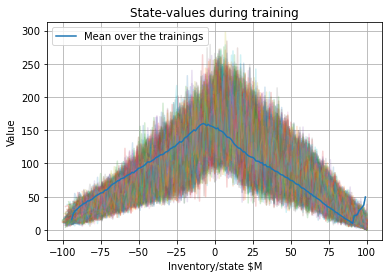

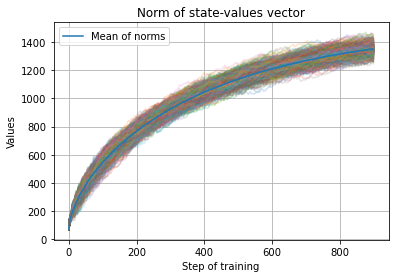

In [5]:
#PLOT STATES VALUES
import statistics
import pandas as pd

polArr=pd.DataFrame()
sVArr=pd.DataFrame()
unsArr=pd.DataFrame()
normsVal=pd.DataFrame()

for i in range(len(thePolicyArr)):
    polArr = polArr.append(thePolicyArr[i], ignore_index=True)
    sVArr = sVArr.append(stateValuesArr[i], ignore_index=True)
    unsArr = unsArr.append(unsortedArr[i], ignore_index=True)
    normsVal = normsVal.append(normStatesValArr[i], ignore_index=True)

    plt.plot(stateValuesArr[i].keys(),stateValuesArr[i].values(), alpha = 0.2)
meanPol = dict(polArr.mean())
meansVArr = dict(sVArr.mean())
meanunsArr = dict(unsArr.mean())

plt.plot(np.linspace(-94,99,len(meansVArr.values())-15),list(meansVArr.values())[0:len(meansVArr.values())-15],label="Mean over the trainings",)
plt.title('State-values during training')
plt.xlabel('Inventory/state $M')
plt.ylabel('Value')
plt.grid()
plt.legend()
plt.savefig('StatesValMethod1', dpi=500)
plt.show()

#PRINT NORM CONVERGENCE
for i in range(len(thePolicyArr)):
    plt.plot(normStatesValArr[i], alpha = 0.2)
NormMeans = np.mean(normStatesValArr, axis=0)
plt.plot(NormMeans, label='Mean of norms')
plt.grid()
plt.title('Norm of state-values vector')
plt.xlabel('Step of training')
plt.ylabel('Values')
plt.legend()
plt.savefig('meanNorms', dpi=500)
plt.show()


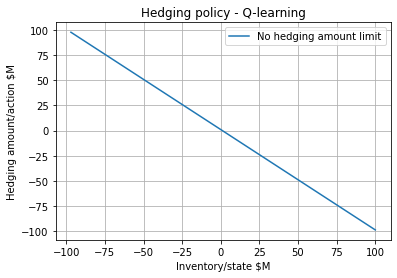

In [239]:
#PLOT THE POLICY
import csv

StateAction = {}
theirValues = {}
imp = 0.5
allPosibleHedgeAmounts=list(np.linspace(-100,100,2001))
statesValNew = dict(meanPol)

#for key in statesValNew:    
#    statesValNew[key] *= 0.005


#try with cap at 10 M max hedge
StateAction = {}
theirValues = {}
imp = 0.5
allPosibleHedgeAmounts=list(np.linspace(-100,100,2001))
statesValNew = dict(meanunsArr)

for currentInv in statesValNew.keys():
  currentInv = float(currentInv)
  value_max = -999
  action = 0
  for p in allPosibleHedgeAmounts:
      #TODO if below 0 reward then does not make sense
      next_inv = currentInv
      next_inv = currentInv + p
      next_stateHash = str(next_inv)

      currStateHash = str(currentInv)
      currValue = 0 if statesValNew.get(currStateHash) is None else statesValNew.get(currStateHash)
      value = 0 if statesValNew.get(next_stateHash) is None else statesValNew.get(next_stateHash)
      if (value - currValue) - abs(float(p))*imp >= value_max:
          value_max = (value - currValue) - abs(float(p))*imp#value
          action = p
          currVal = (value - currValue) -  abs(float(p))*imp#value
  StateAction[currentInv] = action#str(action) + str(currVal)
  theirValues[currentInv] = currVal
    
stateActionPolicyAfterTraining = StateAction
stateActionPolicyAfterTraining = collections.OrderedDict(sorted(stateActionPolicyAfterTraining.items()))
plt.plot(list(stateActionPolicyAfterTraining.keys()), list(stateActionPolicyAfterTraining.values()))

plt.grid()
plt.title('Hedging policy - Q-learning')
plt.xlabel('Inventory/state $M')
plt.ylabel('Hedging amount/action $M')
plt.legend(['No hedging amount limit', '15 $M limit', '30 $M limit', '50 $M limit'])
plt.savefig('hedgingModel1', dpi = 500)
plt.show()

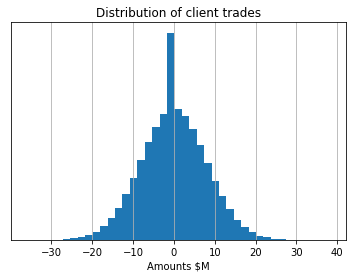

In [216]:
import matplotlib.pyplot as plt
arr = []
for i in range(0,1000000):
    #get amount and sign of client trade
    deltaA = 0.95
    deltaB = 0.5
    At = np.random.binomial(1, deltaA) #Page 6 in Alvaro
    Bt = np.random.binomial(1, deltaB)
    D = (At * (2*Bt-1))
    clientAction = np.random.normal(0,8,1)[0]*D
    arr.append(clientAction)
    
ax = plt.hist(arr, bins = 41)
plt.grid()
plt.title('Distribution of client trades')
plt.xlabel('Amounts $M')
ax = plt.gca()
ax.axes.yaxis.set_visible(False)
ax.set_yticks([])
plt.savefig('distributionClientTrades', dpi = 1000)
plt.show()

In [ ]:
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt
X = np.linspace(-5,5,50)

Y = np.linspace(-5,5,50)

X, Y = np.meshgrid(X,Y)

X_mean = 0; Y_mean = 0

X_var = 5; Y_var = 8

pos = np.empty(X.shape+(2,))

pos[:,:,0]=X

pos[:,:,1]=Y

rv = multivariate_normal([X_mean, Y_mean],[[X_var, 0], [0, Y_var]])

fig = plt.figure()

ax = fig.add_subplot(111, projection='3d')

ax.plot_surface(X, Y, rv.pdf(pos), cmap="plasma")
plt.title('Visualisation of gradient ascent')
plt.savefig('GradAscent', dpi=500)
plt.show()